In [24]:
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [25]:
df = pd.read_csv("GraphicalAnalysis_Assets.csv")
df.index= pd.to_datetime(df["date"])
df.drop(['date'], axis='columns', inplace=True)
data = df.copy()
data.head()
data.tail()

,World Equities,US Treasuries,Bond Risk Premium,Inflation Protection,Currency Protection,US Equities,Real Estate,Commodities,Corp Bonds
date,,,,,,,,,
2000-01-09,0.028511,0.031500,0.006408,-0.016265,0.030292,0.081301,0.056605,0.021351,0.048963
2000-01-16,-0.009204,-0.044692,0.057381,0.006362,0.010258,0.030075,0.016448,-0.015217,-0.042029
2000-01-23,0.075134,0.028719,-0.024396,-0.002848,-0.020739,-0.007299,-0.006716,0.037171,0.032666
2000-01-30,-0.002459,0.023084,-0.004869,0.003089,0.008187,-0.012255,0.000906,-0.035116,0.037125
2000-02-06,0.040245,0.086780,-0.044417,0.004077,-0.002219,0.064516,0.027241,0.004351,0.104199


,World Equities,US Treasuries,Bond Risk Premium,Inflation Protection,Currency Protection,US Equities,Real Estate,Commodities,Corp Bonds
date,,,,,,,,,
2007-09-09,-0.008206,0.017547,-0.015893,-0.002722,0.016414,0.035370,0.032870,0.015722,0.004987
2007-09-16,-0.026838,0.012952,-0.009821,0.004692,0.005149,-0.000469,0.031810,0.006325,-0.001790
2007-09-23,0.035704,-0.022824,0.034039,-0.002079,0.010278,0.030346,0.016921,-0.035008,0.006016
2007-09-30,-0.018291,0.023364,-0.016290,0.000027,0.005631,0.035904,0.018466,0.026868,0.007723
2007-10-07,0.010218,-0.035022,0.042517,-0.001682,0.001178,0.003224,-0.032415,0.060332,-0.004578


In [26]:
#import all the necessary packages

import warnings
warnings.filterwarnings('ignore')

import numpy as np #for numerical array data
import pandas as pd #for tabular data
import matplotlib.pyplot as plt #for plotting purposes
import matplotlib.pylab as pl #for plotting purposes

import csv
from datetime import datetime, timedelta

from matplotlib.collections import LineCollection #for plotting purposes
from sklearn import cluster, covariance, manifold #for graphical analysis

In [27]:
# ############################################################################################################################
# FUNCTIONS USED FOR GRAPHICAL ANALYSIS
# ############################################################################################################################

# Reference: https://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html

# #############################################################################
# Function for performing graphical network analysis
# Print clusters information, graphical network information, summary statistics, and plot of individual firm performance
# Return correlation and precision matrix, as well as plotting configuration information
# NOTE: it will drop the firms that have missing data during the specified time period

def graphicalAnalysis(dataset, start_date = '2000-01-01', end_date = '2020-05-31', 
                      Sectors_chosen = [],
                      drop_asset_classes = []):
    
    # Check if the inputed date are legit
    if(datetime.strptime(start_date, "%Y-%m-%d") > datetime.strptime(end_date, "%Y-%m-%d")):
        print('ERROR: Revision needed! The entered \"start_date\" should be before \"end_date\".')
        return 0,0
    if (dataset.index[0]- timedelta(days=dataset.index[0].weekday()) > datetime.strptime(start_date, "%Y-%m-%d")):
        print('WARNING: the entered \"start_date\" is outside of the range for the given dataset.')
        print('The \"start_date\" is adjusted to the earliest start_date, i.e. ',
              (dataset.index[0]-timedelta(days=dataset.index[0].weekday())).strftime("%Y-%m-%d"))
        print()
    if (dataset.index[-1] < datetime.strptime(end_date, "%Y-%m-%d")):
        print('WARNING: the entered \"end_date\" is outside of the range for the given dataset.')
        print('The \"end_date\" is adjusted to the lastest end_date, i.e. ',
              dataset.index[-1].strftime("%Y-%m-%d"))
        print()
    
    # Extract the data for the given time period
    temp = dataset[dataset.index >= start_date].copy()
    X = temp[temp.index <= end_date].copy()    

    # Check if we are using all Asset Classes or dropping some Asset Classses
    if((not drop_asset_classes) == False):
        if(all([(f in X.columns) for f in drop_asset_classes])):
            print('The following Asset Classes are dropped:')
            print(drop_asset_classes)
            print()
            X.drop(columns = drop_asset_classes, inplace = True)
        else:
            print('ERROR: Revision needed! At Least 1 Asset Class entered in the \"drop_asset_classes\" option is NOT in the dataset!')
            print('Check your format!')
            return 0,0
    
    # Check if there is NA in the dataset within the given time period
    # If yes, then drop those firms before doing graphical analysis
    if(X.isnull().values.any()):
        print('WARNING: Some Asset classes have missing data during this time period!')
        print('Dropping Asset classes: ')
        for Xcol_dropped in list(X.columns[X.isna().any()]): print(Xcol_dropped)
        X = X.dropna(axis='columns')
        print()
    
    # Get the Start and End date of the dataset
    date_obj = X.index[0]
    start_of_week = date_obj - timedelta(days=date_obj.weekday())
    start = start_of_week.strftime("%m/%d/%Y")
    end =  X.index[-1].strftime("%m/%d/%Y")
    
    # Get the Asset Classes names of the dataset
    names = np.array(list(X.columns))
    
    # Show the number of Asset Classes examined
    print('Number of Asset Classes examined:', X.shape[1])
    
    
    # #############################################################################
    # Learn a graphical structure from the correlations
    
    # Graphical Lasso is used here to estimate the precision matrix    
    edge_model = covariance.GraphicalLassoCV(max_iter=1000)

    # standardize the time series: 
    # using correlations rather than covariance is more efficient for structure recovery
    X_std = X / X.std(axis=0)
    edge_model.fit(X_std)
    
    # #############################################################################
    # Cluster using affinity propagation

    _, labels = cluster.affinity_propagation(edge_model.covariance_)
    n_labels = labels.max()
    
    for i in range(n_labels + 1):
        print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))

    # #############################################################################
    # Find a low-dimension embedding for visualization: find the best position of
    # the nodes (the stocks) on a 2D plane

    node_position_model = manifold.MDS(n_components=2, random_state=0)
    embedding = node_position_model.fit_transform(X_std.T).T

    # #############################################################################
    # Visualization I
    
    # Specify node colors by cluster labels 
    color_list = pl.cm.jet(np.linspace(0,1,n_labels+1))
    my_colors = [color_list[i] for i in labels]
    
    # Compute the partial correlations
    partial_correlations = edge_model.precision_.copy()
    d = 1 / np.sqrt(np.diag(partial_correlations))
    partial_correlations *= d
    partial_correlations *= d[:, np.newaxis]
    non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)
    
    # Compute the edge values based on the partial correlations
    values = np.abs(partial_correlations[non_zero])
    val_max = values.max()
    
    # Title of the plot
    title = 'Graphical Network Analysis of Selected Firms over the Period '+start+' to '+end+' (Weekly)'
    
    # Display the partial correlation graph
    graphicalAnalysis_plot(d, partial_correlations, my_colors,
                           names, labels, embedding, val_max, title)   
# END of function graphicalAnalysis

In [28]:
###########################################   CAN BE CHANGED  #############################################

## Start and End date we are considering:
start_date = '2000-01-09'
end_date   = '2007-10-07'

## The list of firms we want to drop:
drop_asset_classes = []

###########################################   CAN BE CHANGED  #############################################

In [29]:
# #############################################################################
# Function Used for plotting the graphical network graph
def graphicalAnalysis_plot(d, partial_correlations, my_colors,
                           names, labels, embedding, val_max, title):
        
    non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)
    n_labels = labels.max()
    
    #For correlation network graph
    fig = plt.figure(1, facecolor='w', figsize=(12, 5))
    plt.clf()
    ax = plt.axes([0., 0., 1., 1.])
    plt.axis('off')

    # Plot the nodes using the coordinates of our embedding
    plt.scatter(embedding[0], embedding[1], s=500 * d ** 2, c= my_colors)

    # Plot the edges
    start_idx, end_idx = np.where(non_zero)
    # a sequence of (*line0*, *line1*, *line2*), where::
    #            linen = (x0, y0), (x1, y1), ... (xm, ym)
    segments = [[embedding[:, start], embedding[:, stop]]
                for start, stop in zip(start_idx, end_idx)]
    values = np.abs(partial_correlations[non_zero])
    lc = LineCollection(segments,
                        zorder=0, cmap=plt.cm.hot_r, 
                        norm=plt.Normalize(0, .7 * val_max))
    lc.set_array(values)
    temp = (15 * values)
    temp2 = np.repeat(5, len(temp))
    w = np.minimum(temp, temp2)
    lc.set_linewidths(w)
    ax.add_collection(lc)
    axcb = fig.colorbar(lc)
    axcb.set_label('Strength')

    # Add a label to each node. The challenge here is that we want to
    # position the labels to avoid overlap with other labels
    for index, (name, label, (x, y)) in enumerate(
            zip(names, labels, embedding.T)):

        dx = x - embedding[0]
        dx[index] = 1
        dy = y - embedding[1]
        dy[index] = 1
        this_dx = dx[np.argmin(np.abs(dy))]
        this_dy = dy[np.argmin(np.abs(dx))]
        if this_dx > 0:
            horizontalalignment = 'left'
            x = x + .002
        else:
            horizontalalignment = 'right'
            x = x - .002
        if this_dy > 0:
            verticalalignment = 'bottom'
            y = y + .002
        else:
            verticalalignment = 'top'
            y = y - .002
        plt.text(x, y, name, size=10,
                 horizontalalignment=horizontalalignment,
                 verticalalignment=verticalalignment,
                 bbox=dict(facecolor='w',
                           edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
                           alpha=.6))

    plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
             embedding[0].max() + .10 * embedding[0].ptp(),)
    plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
             embedding[1].max() + .03 * embedding[1].ptp())
    plt.title(title)
    plt.show()
# END of function graphicalAnalysis_plot
# #############################################################################

Results over the time period  2000-01-09  to  2007-10-07 :

Number of Asset Classes examined: 9
Cluster 1: Inflation Protection
Cluster 2: Currency Protection
Cluster 3: World Equities, Bond Risk Premium, US Equities, Real Estate, Commodities
Cluster 4: US Treasuries, Corp Bonds


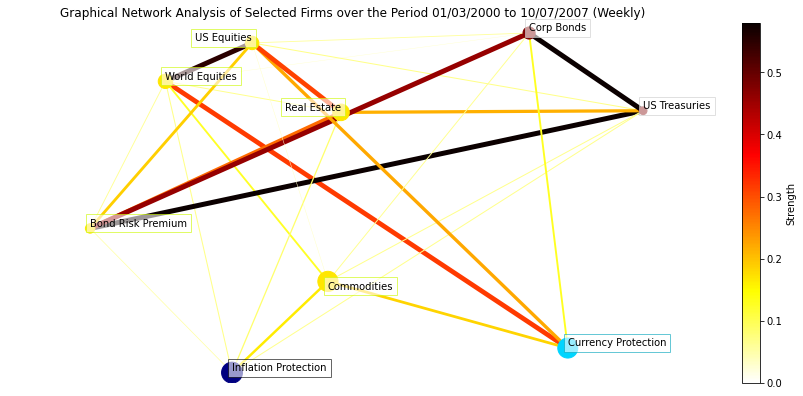

In [30]:
print('Results over the time period ', start_date, ' to ', end_date, ':')
print()

# Output the Clustering information, graphical network plot, 
# as well as summary statistics (optional) and the individual Asset Class performance (optional)
# Store the correlation matrix and precision matrix in "est" (stands for estimates)
# Store the plotting configuration information in "con_fig" which will be needed if we want to use the ZOOM functions
## Note: you can view the correlation matrix by looking at est[0] and view the precision matrix by looking at est[1] 
graphicalAnalysis(data, start_date, end_date,drop_asset_classes)